# Feature Selection

In [7]:
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
import multiprocessing

In [2]:
### Realizamos el cambio de directoroi de trabajo al "Directorio Base" que se
current_dir = os.getcwd()
base_path = os.path.dirname(current_dir)

os.chdir(base_path)

In [3]:
import scripts.auxiliares.GA as GA
import scripts.funciones as funciones
from scripts.clase_model.modelo import Modelo

C:\Users\pasal\Anaconda3\envs\PI2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Carga y Preparación de Datos

In [5]:
d_ini = dt.datetime(2017,6,1)
d_fin = dt.datetime(2019,8,1)  

In [8]:
version = 'verFinal'

### params
freq1 = '1D'
freq2 = '3D'
freq3 = '7D'
freq4 = '14D'
freq5 = '30D'
freq6 = '60D'
n_proc = multiprocessing.cpu_count() -1

### Realizamos la lectura de la informacion climatica en el rango de fechas
### especificado, incluye la etiqueta de si ocurre o no un accidente. 
### Posteriormente, en la organizacion de la informacion climatica, lo
### que se hace es agregar las variables con la informacion distribucional
### de las ultimas 5 horas de la info climatica
data = funciones.read_clima_accidentes(d_ini, d_fin, poblado = True)
data_org = funciones.organizar_data_infoClima(data)


### agregamos la informacion relacionada a la cantidad de accidentes ocurridas
### en las ultimas X horas
### Agregar senales
senales = [freq1, freq2, freq3, freq4, freq5, freq6]
d_ini_acc = d_ini - dt.timedelta(days = int(freq6.replace('D', '')))  ### freq mayor
raw_accidentes = funciones.read_accidentes(d_ini_acc, d_fin)
for fresen in senales:
    data_org = funciones.obtener_accidentes_acumulados(data_org, 
                                                        raw_accidentes, 
                                                        freq = fresen)


### Convertimos la bariable de Barrios en variable dummy para ser incluida
### en el modelo
data_org['poblado'] = data_org['BARRIO']
data_org= pd.get_dummies(data_org, columns=['poblado'])

### Relizamos la particion del conjunto de datos en las variables
### explicativas (X) y la variable respuesta (Y)
X = data_org.drop(columns = ['TW','BARRIO','Accidente','summary'])
Y = data_org['Accidente']       

In [9]:
### Dividimos el conjunto de datos en entrenamiento y validacion
X_train, X_val, Y_train, Y_val = train_test_split(X,
                                                  Y,
                                                  test_size=0.2, 
                                                  random_state=42)

train_indices = X_train.index.values
val_indices = X_val.index.values

In [10]:
### Realizamos undersampling al conjunto de entrenamiento

prop_deseada_under = 0.4

can_0 = len(Y_train) - Y_train.sum()
can_1 = Y_train.sum()

tra_0 = int(len(Y_train) - Y_train.sum())
tra_1 = int(Y_train.sum())

mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)    
fac_1 = int(tra_0 * (1 - mul_updown))

ratio_u = {0 : fac_1, 1 : tra_1}
rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)

X_train_under, Y_train_under = rus.fit_sample(X_train, Y_train)

In [11]:
train_indices = rus.sample_indices_
test_indices = X_val.index.values

In [12]:
### Estandarizacion del conjunto de datos
scaler = StandardScaler()
scaler.fit(X_train_under)

X_train_under_z = pd.DataFrame(scaler.transform(X_train_under), columns = X_train_under.columns)
X_val_z = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)

X_z = pd.DataFrame(scaler.transform(X), columns = X.columns)

In [13]:
print(f'Se cuentan con {len(X_train.columns)} variables para la seleccion')

Se cuentan con 108 variables para la seleccion


# Lasso Variable Selection

In [12]:
%%time

C = np.arange(1, 10**1, 1)
par = {'C': C}

lasso_mod = GridSearchCV(LogisticRegression(penalty = 'l1', solver = 'liblinear'), 
                         par,
                         scoring = 'roc_auc',
                         cv = 2,
                         verbose = 2,
                         n_jobs = n_proc)

lasso_mod.fit(X_train_under_z, Y_train_under)
coeficientes = lasso_mod.best_estimator_.coef_[0]

res = pd.DataFrame()
res['Var'] = X_train.columns
res['coef'] = coeficientes
res['coef_abs'] = res['coef'].abs()

vars_lasso = res[res['coef_abs']>0].Var.values

### Evaluacion del modelo con las variables obtenidas
clf_lasso = RandomForestClassifier(bootstrap=True,  
                             criterion='entropy',
                             max_features='auto',
                             n_estimators=100, 
                             random_state=42,
                             warm_start=True)

clf_lasso.fit(X_train_under_z[vars_lasso], Y_train_under)

### Metricas en validation

preds_val = clf_lasso.predict_proba(X_val_z[vars_lasso])
ROC_val_lasso = roc_auc_score(Y_val,preds_val[:,1])

print(f'Se seleccionaron {len(vars_lasso)} variables, se obtuvo un ROC-AUC de {ROC_val_lasso} en Validacion\n')
print(vars_lasso)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   7 out of  18 | elapsed:    8.5s remaining:   13.4s
[Parallel(n_jobs=11)]: Done  18 out of  18 | elapsed:   17.0s finished


Se seleccionaron 73 variables, se obtuvo un ROC-AUC de 0.7532485855572821 en Validacion

['precipIntensity' 'precipProbability' 'temperature' 'apparentTemperature'
 'dewPoint' 'humidity' 'windSpeed' 'cloudCover' 'uvIndex' 'visibility'
 'hora_0' 'hora_1' 'hora_2' 'hora_3' 'hora_4' 'hora_5' 'hora_6' 'hora_9'
 'hora_10' 'hora_11' 'hora_12' 'hora_13' 'hora_14' 'hora_15' 'hora_16'
 'hora_17' 'hora_18' 'hora_19' 'hora_20' 'hora_21' 'hora_22' 'hora_23'
 'icon_clear-day' 'icon_clear-night' 'icon_cloudy' 'icon_fog'
 'icon_partly-cloudy-day' 'icon_rain' 'dia_sem_0' 'dia_sem_1' 'dia_sem_3'
 'dia_sem_4' 'dia_sem_5' 'dia_sem_6' 'cloudCover_mean' 'dewPoint_mean'
 'humidity_mean' 'precipIntensity_mean' 'visibility_mean' 'windSpeed_mean'
 'cumAcc_96H' 'cumAcc_336H' 'poblado_alejandria' 'poblado_altosdelpoblado'
 'poblado_astorga' 'poblado_barriocolombia' 'poblado_castropol'
 'poblado_elcastillo' 'poblado_eldiamanteno2' 'poblado_elpoblado'
 'poblado_eltesoro' 'poblado_laaguacatala' 'poblado_laflorida'


# Forward Variable Selection

In [13]:
%%time

### Seleccion de variables con un Forward Selection
clf = RandomForestClassifier(bootstrap=True,  
                             criterion='entropy',
                             max_features='auto',
                             n_estimators=5, 
                             random_state=42,
                             warm_start=True)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features='best',
           forward=True,
           floating=False,
           verbose=2,
           scoring='roc_auc',
           cv=2,
           n_jobs = n_proc)

# Perform SFFS
sfs1 = sfs1.fit(X_train_under_z, Y_train_under)

# Which features?
feat_cols = list(sfs1.k_feature_idx_)
var_relevant = list(X_train_under_z.columns[feat_cols])

### Evaluacion del modelo con las variables obtenidas
clf_forward = RandomForestClassifier(bootstrap=True,  
                             criterion='entropy',
                             max_features='auto',
                             n_estimators=100, 
                             random_state=42,
                             warm_start=True)

clf_forward.fit(X_train_under_z[var_relevant], Y_train_under)

### Metricas en validation

preds_val = clf_forward.predict_proba(X_val_z[var_relevant])
ROC_val_forward = roc_auc_score(Y_val,preds_val[:,1])

print(f'Se seleccionaron {len(var_relevant)} variables, se obtuvo un ROC-AUC de {ROC_val_forward} en Validacion\n')
print(var_relevant)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=11)]: Done  80 out of  80 | elapsed:    0.7s finished

[2020-05-06 16:39:20] Features: 1/80 -- score: 0.6807618789488947[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done  58 out of  79 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=11)]: Done  79 out of  79 | elapsed:    0.6s finished

[2020-05-06 16:39:21] Features: 2/80 -- score: 0.7004194746052671[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=11)]: Done  57 out of  78 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=11)]: Done  78 out of  78 | elapsed:    0.6s finished

[2020-05-06 16:39:21] Features: 3/80 -- score: 0.7125038979833733[Parallel(

[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=11)]: Done  34 out of  55 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=11)]: Done  55 out of  55 | elapsed:    0.8s finished

[2020-05-06 16:39:40] Features: 26/80 -- score: 0.7347520270942018[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=11)]: Done  54 out of  54 | elapsed:    0.8s finished

[2020-05-06 16:39:41] Features: 27/80 -- score: 0.7324685401042444[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=11)]: Done  32 out of  53 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=11)]: Done  53 out of  53 | elapsed:    0.8s finished

[2020-05-06 16:39:42] Features: 28/80 -- score: 0.7293142849748839[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parall

[Parallel(n_jobs=11)]: Done  19 out of  26 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=11)]: Done  26 out of  26 | elapsed:    0.7s finished

[2020-05-06 16:40:06] Features: 55/80 -- score: 0.6992283169262533[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  17 out of  25 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=11)]: Done  25 out of  25 | elapsed:    0.7s finished

[2020-05-06 16:40:07] Features: 56/80 -- score: 0.7004822909677628[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  16 out of  24 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=11)]: Done  24 out of  24 | elapsed:    0.6s finished

[2020-05-06 16:40:07] Features: 57/80 -- score: 0.703049164499551[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  14 out of  23 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=11)]: Done  23 

Se seleccionaron 13 variables, se obtuvo un ROC-AUC de 0.7439698657973346 en Validacion

['hora_0', 'hora_1', 'hora_2', 'hora_3', 'hora_4', 'hora_5', 'hora_22', 'hora_23', 'icon_partly-cloudy-day', 'dia_sem_6', 'cumAcc_336H', 'poblado_eldiamanteno2', 'poblado_sanlucas']
Wall time: 1min 5s


# Algoritmo Genético para Selección de Características

In [14]:
### Modelo base de la envoltura
classifier = RandomForestClassifier(max_depth = 10, random_state= 42, bootstrap = True, n_estimators = 5)

Mejor solucion :  [0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0
 1 0 0 1 0 0]
Indices seleccionados :  [ 2  4 10 12 13 16 17 18 21 23 24 31 33 34 39 40 42 43 44 47 57 58 59 60
 63 64 66 67 68 69 71 74 77]
Numero de variables seleccionadas :  33
ROC-AUC de la mejor solucion de todo el algoritmo :  0.7266141156114541


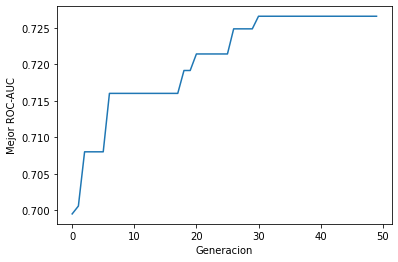

Wall time: 3min 2s


In [15]:
%%time
### Ejecucion del Algoritmo Genetico

### Hiperparametros
num_samples = X_train_under_z.shape[0]
num_feature_elements = X_train_under_z.shape[1]

num_generations = 5#50   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)

data_inputs, data_outputs = X_z.values, Y.values

### Correr el algoritmo genético
best_solution, best_solution_indices, best_solution_num_elements, best_solution_fitness = GA.genetic_algorithm(X_train,num_generations, sol_per_pop, porc_mutation, porc_genes,
                                                                                                              num_feature_elements,data_inputs, data_outputs, 
                                                                                                              train_indices, test_indices, classifier, num_mutations,num_genes)


In [16]:
### Las variables obtenidas son
vars_obt = []
for i in range(len(best_solution)):
    if best_solution[i]==1:
        vars_obt.append(X.columns[i])

### Evaluacion del modelo con las variables obtenidas
clf_AG = RandomForestClassifier(bootstrap=True,  
                             criterion='entropy',
                             max_features='auto',
                             n_estimators=100, 
                             random_state=42,
                             warm_start=True)

clf_AG.fit(X_train_under_z[vars_obt], Y_train_under)

### Metricas en validation

preds_val = clf_AG.predict_proba(X_val_z[vars_obt])
ROC_val_AG = roc_auc_score(Y_val,preds_val[:,1])
        
print(f'Se seleccionaron {len(vars_obt)} variables, se obtuvo un ROC-AUC de {ROC_val_AG} en Validacion\n')
print(vars_obt)

Se seleccionaron 33 variables, se obtuvo un ROC-AUC de 0.730873863562611 en Validacion

['temperature', 'dewPoint', 'hora_0', 'hora_2', 'hora_3', 'hora_6', 'hora_7', 'hora_8', 'hora_11', 'hora_13', 'hora_14', 'hora_21', 'hora_23', 'icon_clear-day', 'icon_partly-cloudy-night', 'icon_rain', 'dia_sem_1', 'dia_sem_2', 'dia_sem_3', 'dia_sem_6', 'cumAcc_336H', 'poblado_alejandria', 'poblado_altosdelpoblado', 'poblado_astorga', 'poblado_elcastillo', 'poblado_eldiamanteno2', 'poblado_eltesoro', 'poblado_laaguacatala', 'poblado_laflorida', 'poblado_lalinde', 'poblado_laslomasno2', 'poblado_losnaranjos', 'poblado_sanlucas']


# Guardamos los resultados obtenidos

En un archivo JSON guardamos los resultados de los 3 metodos

In [17]:
Resultados = {'lasso':{'num_features':len(vars_lasso),
                       'roc_val': ROC_val_lasso,
                       'features':list(vars_lasso)},
              'forward':{'num_features':len(var_relevant),
                       'roc_val': ROC_val_forward,
                       'features':var_relevant},
              'AG':{'num_features':len(vars_obt),
                    'roc_val': ROC_val_AG,
                    'features':vars_obt}
              }


with open(f'{base_path}/models/{version}/analisis_var_relevantes.json','w') as json_file:
    json.dump(Resultados, json_file)